In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.utils.data as data
from torchvision import datasets
from sklearn import metrics
import seaborn as sns
from sklearn import metrics
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [2]:
def import_depth_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Depth/a{action}_s{subject}_t{trial}_depth.mat'# The name of the .mat files
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_depth']
    else:
        return None

def transform_depth_data(action, subject, trial):
    rows = []
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        pixels = data[:, :, frame].flatten()
        rows.append(pixels)
    result = np.insert(rows, 0, [[action], [subject], [trial], [frame]], axis=1)
    return np.array(result)

def transform_depth_data_to_df(action, subject, trial):
    data = transform_depth_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame'] + [f'depth_{n}' for n in range(240 * 320)]
    return df

def export_depth_data_to_csv(action, subject, trial):
    df = transform_depth_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_depth.csv'
    df.to_csv(filename, index=False)

def show_depth_image(action, subject, trial, frame):
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    plt.imshow(data[:,:,frame], cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
def import_inertial_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_iner']
    else:
        return None
    
def transform_inertial_data(action, subject, trial):
    data = import_inertial_data(action, subject, trial)
    if data is None: return None
    result = np.insert(data, 0, [[action], [subject], [trial]], axis=1)
    return np.array(result)

def transform_inertial_data_to_df(action, subject, trial):
    data = transform_inertial_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'x-accel', 'y-accel', 'z-accel', 'x-ang-accel', 'y-ang-accel', 'z-ang-accel']
    return df

In [4]:
activities = [i for i in range(1,28)]
raw_dataframe = transform_inertial_data_to_df(0, 0, 0)
for index, action in enumerate(activities):
    for subject in range(1, 9):
        for trial in range(1, 5):
            data = transform_inertial_data_to_df(action, subject, trial) # (160, 6)
            if data is None: continue
            #data = data[0:128] #(128.6) # maximum length is 128
            raw_dataframe = pd.concat([raw_dataframe, data])
raw_dataframe

,action,subject,trial,x-accel,y-accel,z-accel,x-ang-accel,y-ang-accel,z-ang-accel
0,1.0,1.0,1.0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672
1,1.0,1.0,1.0,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275
2,1.0,1.0,1.0,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237
3,1.0,1.0,1.0,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611
4,1.0,1.0,1.0,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412
...,...,...,...,...,...,...,...,...,...
250,27.0,8.0,3.0,-0.908936,0.045410,0.541992,-1.801527,0.427481,0.000000
251,27.0,8.0,3.0,-0.909668,0.055176,0.532471,-2.076336,0.335878,0.244275
252,27.0,8.0,3.0,-0.916748,0.050781,0.528320,-1.954198,0.396947,0.305344
253,27.0,8.0,3.0,-0.915039,0.041260,0.534424,-1.648855,0.244275,0.213740


In [5]:
# window_size: size of time window
# step: overlapping
# data: dataset
def time_windows(window_size,overlapping,data):
  sigmentation_data_temp = []
  sigmentation_data = []
  sigmentation_label = []
  for i in range(0,len(data),overlapping):
    acc_x = data['x-accel'].values[i:i+window_size]
    acc_y = data['y-accel'].values[i:i+window_size]
    acc_z = data['z-accel'].values[i:i+window_size]
    gyro_x = data['x-ang-accel'].values[i:i+window_size]
    gyro_y = data['y-ang-accel'].values[i:i+window_size]
    gyro_z = data['z-ang-accel'].values[i:i+window_size]
    total_label = data['action'].values[i:i+window_size]
    label = Counter(total_label).most_common()[0][0]
    sigmentation_data_temp.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
    sigmentation_arr = np.asarray(sigmentation_data_temp)
    sig_size = sigmentation_arr.shape
    if sig_size[2] == window_size:
      sigmentation_arr.reshape(window_size,6)
      sigmentation_data.append(sigmentation_arr)
      sigmentation_label.append(label)
      sigmentation_data_temp = []
    else:
      sigmentation_data_temp = []

  sigmentation_data_arr = np.asarray(sigmentation_data)
  sigmentation_label_arr = np.asarray(sigmentation_label)

  return sigmentation_data_arr,sigmentation_label_arr

In [6]:
utd_readings,utd_labels = time_windows(128,64 + 32 ,raw_dataframe)

In [7]:
print('Shape of data:')
print(utd_readings.shape)
print('Shape of label')
utd_labels.shape

Shape of data:
(1620, 1, 6, 128)
Shape of label


(1620,)

In [8]:
utd_labels -= 1

In [9]:
#split the dataset 
idx_list = np.array(range(1620))
np.random.shuffle(idx_list)
train_idxes = idx_list[:1000]
test_idxes = idx_list[1000:]
train_features = utd_readings[train_idxes]
train_labels = utd_labels[train_idxes]
test_features = utd_readings[test_idxes]
test_labels = utd_labels[test_idxes]
# train_features = np.array([utd_readings[i] for i in train_idxes])
# train_labels = np.array([utd_labels[i] for i in train_idxes])

# test_features = np.array([utd_readings[i] for i in test_idxes])
# test_labels = np.array([utd_labels[i] for i in test_idxes])
# train_features, train_labels = utd_readings, utd_labels
# test_features, test_labels = utd_readings, utd_labels

In [10]:
np.array(train_labels)

array([ 2., 21., 18., 15.,  7.,  9., 23., 22., 15., 15., 14., 22.,  4.,
        0.,  4., 18., 22.,  5., 19.,  2., 11., 17., 16.,  7.,  7., 12.,
        1., 18., 14., 26.,  9.,  8., 14.,  5., 15., 23., 20., 14., 25.,
       19.,  9.,  7.,  4., 16.,  5.,  8., 11., 16., 10.,  5., 17.,  0.,
       19.,  7.,  4., 12., 10.,  8., 26.,  2., 11., 18., 20., 19.,  0.,
       13.,  1., 22., 20.,  3., 23., 24., 12., 19.,  3., 21., 10.,  5.,
        1., 20., 21., 21.,  1., 17., 17., 16.,  4., 15.,  5.,  1.,  0.,
       10., 18.,  7., 24.,  5., 26.,  6.,  0., 11., 14., 23.,  8., 19.,
        1., 25.,  5., 26., 19.,  4., 14.,  9., 26., 10., 12., 24.,  8.,
       16., 10., 25.,  3., 17., 14., 18., 24., 22.,  0., 24., 17., 13.,
       11., 14., 13., 18., 18.,  6., 21., 18., 26., 21., 26.,  9.,  5.,
        7., 10.,  7.,  1., 11.,  3., 20., 20., 17., 21., 10., 22.,  6.,
        3.,  7., 13., 22.,  5.,  0., 12.,  9.,  7., 10., 11.,  6., 19.,
       15.,  4., 17.,  0., 16., 12., 13., 25., 11., 13., 21.,  3

In [11]:
train_dataset = TensorDataset(torch.from_numpy(train_features).to(torch.float32),torch.from_numpy(train_labels).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(test_features).to(torch.float32),torch.from_numpy(test_labels).to(torch.float32))

In [12]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [13]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = 64,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = 64,shuffle = False)

In [14]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [15]:
# Hyper parameter 
BATCH_SIZE = 32 # 
EPOCHES = 10
input_dim = 128 # input dimension
hidden_dim = 1000 # hidden layers number
layer_dim = 1 
output_dim = 27 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [16]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
        

Iter:10,loss:3.24973201751709,Accuracy:43.5
Iter:20,loss:2.6873533725738525,Accuracy:51.89999771118164
Iter:30,loss:2.6368408203125,Accuracy:65.69999694824219
Iter:40,loss:2.360583543777466,Accuracy:69.4000015258789
Iter:50,loss:1.9848012924194336,Accuracy:74.69999694824219
Iter:60,loss:2.0493693351745605,Accuracy:77.30000305175781
Iter:70,loss:1.673087477684021,Accuracy:78.0
Iter:80,loss:1.900891900062561,Accuracy:80.29999542236328
Iter:90,loss:1.861194133758545,Accuracy:83.60000610351562
Iter:100,loss:1.3758498430252075,Accuracy:86.79999542236328
Iter:110,loss:1.455652117729187,Accuracy:88.80000305175781
Iter:120,loss:1.2144458293914795,Accuracy:89.80000305175781
Iter:130,loss:1.0156331062316895,Accuracy:90.9000015258789
Iter:140,loss:1.0761502981185913,Accuracy:93.30000305175781
Iter:150,loss:0.9290701746940613,Accuracy:93.5
Iter:160,loss:1.0171924829483032,Accuracy:96.0


Test Accuracy of the basic LSTM model on the UTD test features: 34.19355010986328 %


Text(241.44, 0.5, 'predicted label')

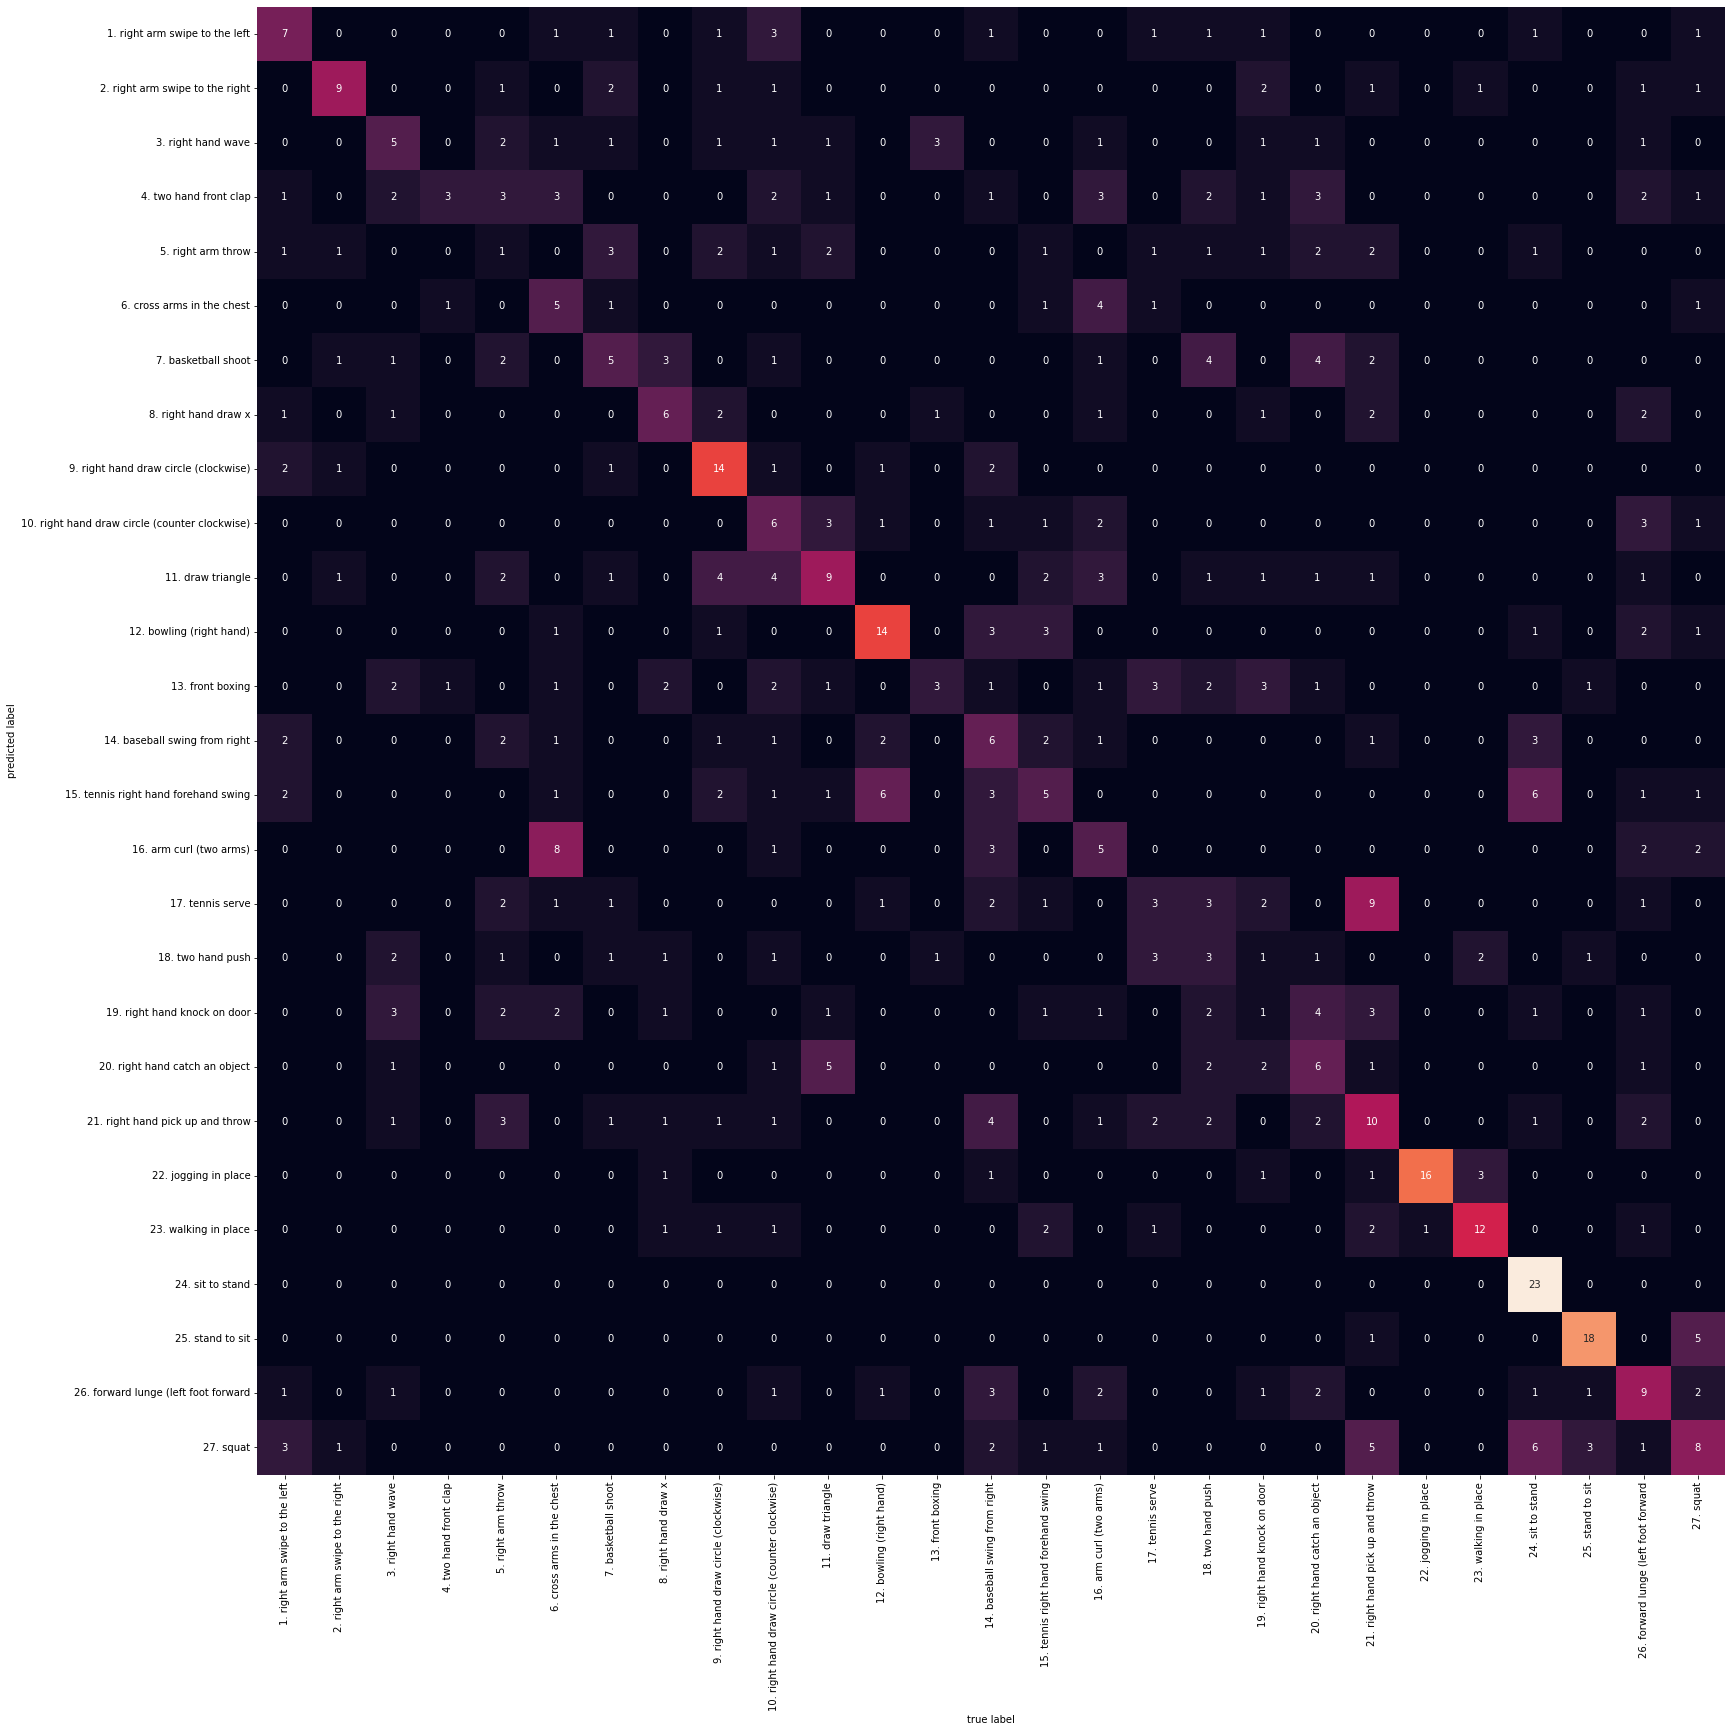

In [17]:
labels_list = []
predictions = []
classes = [
     '1. right arm swipe to the left', 
    '2. right arm swipe to the right', 
    '3. right hand wave',
    '4. two hand front clap',
    '5. right arm throw',
    '6. cross arms in the chest',
    '7. basketball shoot', 
    '8. right hand draw x',
    '9. right hand draw circle (clockwise)',
    '10. right hand draw circle (counter clockwise)',
    '11. draw triangle', 
    '12. bowling (right hand)', 
    '13. front boxing',
    '14. baseball swing from right',
    '15. tennis right hand forehand swing',
    '16. arm curl (two arms)', 
    '17. tennis serve', 
    '18. two hand push',
    '19. right hand knock on door', 
    '20. right hand catch an object',
    '21. right hand pick up and throw',
    '22. jogging in place',
    '23. walking in place',
    '24. sit to stand', 
    '25. stand to sit', 
    '26. forward lunge (left foot forward',
    '27. squat'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(27, 27))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [18]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #循环对象
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        

In [19]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number 
layer_dim = 2
output_dim = 27 + 1 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)

In [21]:
length = (len(list(model_rnn.parameters())))

In [22]:
sequence_dim = 6
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 5 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))
            

Iter:5,loss:10.617862701416016,Accuracy:7.400000095367432
Iter:10,loss:4.411194324493408,Accuracy:10.59999942779541
Iter:15,loss:3.7184410095214844,Accuracy:11.0
Iter:20,loss:3.0981831550598145,Accuracy:13.500000953674316
Iter:25,loss:3.290255069732666,Accuracy:17.700000762939453
Iter:30,loss:3.0520684719085693,Accuracy:20.600000381469727
Iter:35,loss:2.7772228717803955,Accuracy:23.399999618530273
Iter:40,loss:3.028057813644409,Accuracy:25.700000762939453
Iter:45,loss:2.9278178215026855,Accuracy:28.5
Iter:50,loss:2.566619396209717,Accuracy:29.69999885559082
Iter:55,loss:2.701451539993286,Accuracy:30.799999237060547
Iter:60,loss:2.506967544555664,Accuracy:35.29999923706055
Iter:65,loss:2.2907986640930176,Accuracy:36.89999771118164
Iter:70,loss:2.455970525741577,Accuracy:37.0
Iter:75,loss:2.2283551692962646,Accuracy:39.89999771118164
Iter:80,loss:2.462959051132202,Accuracy:38.10000228881836
Iter:85,loss:2.260751247406006,Accuracy:41.70000076293945
Iter:90,loss:1.9981316328048706,Accuracy

Test Accuracy of the basic RNN model on the UTD test features: 16.774194717407227 %


Text(241.44, 0.5, 'predicted label')

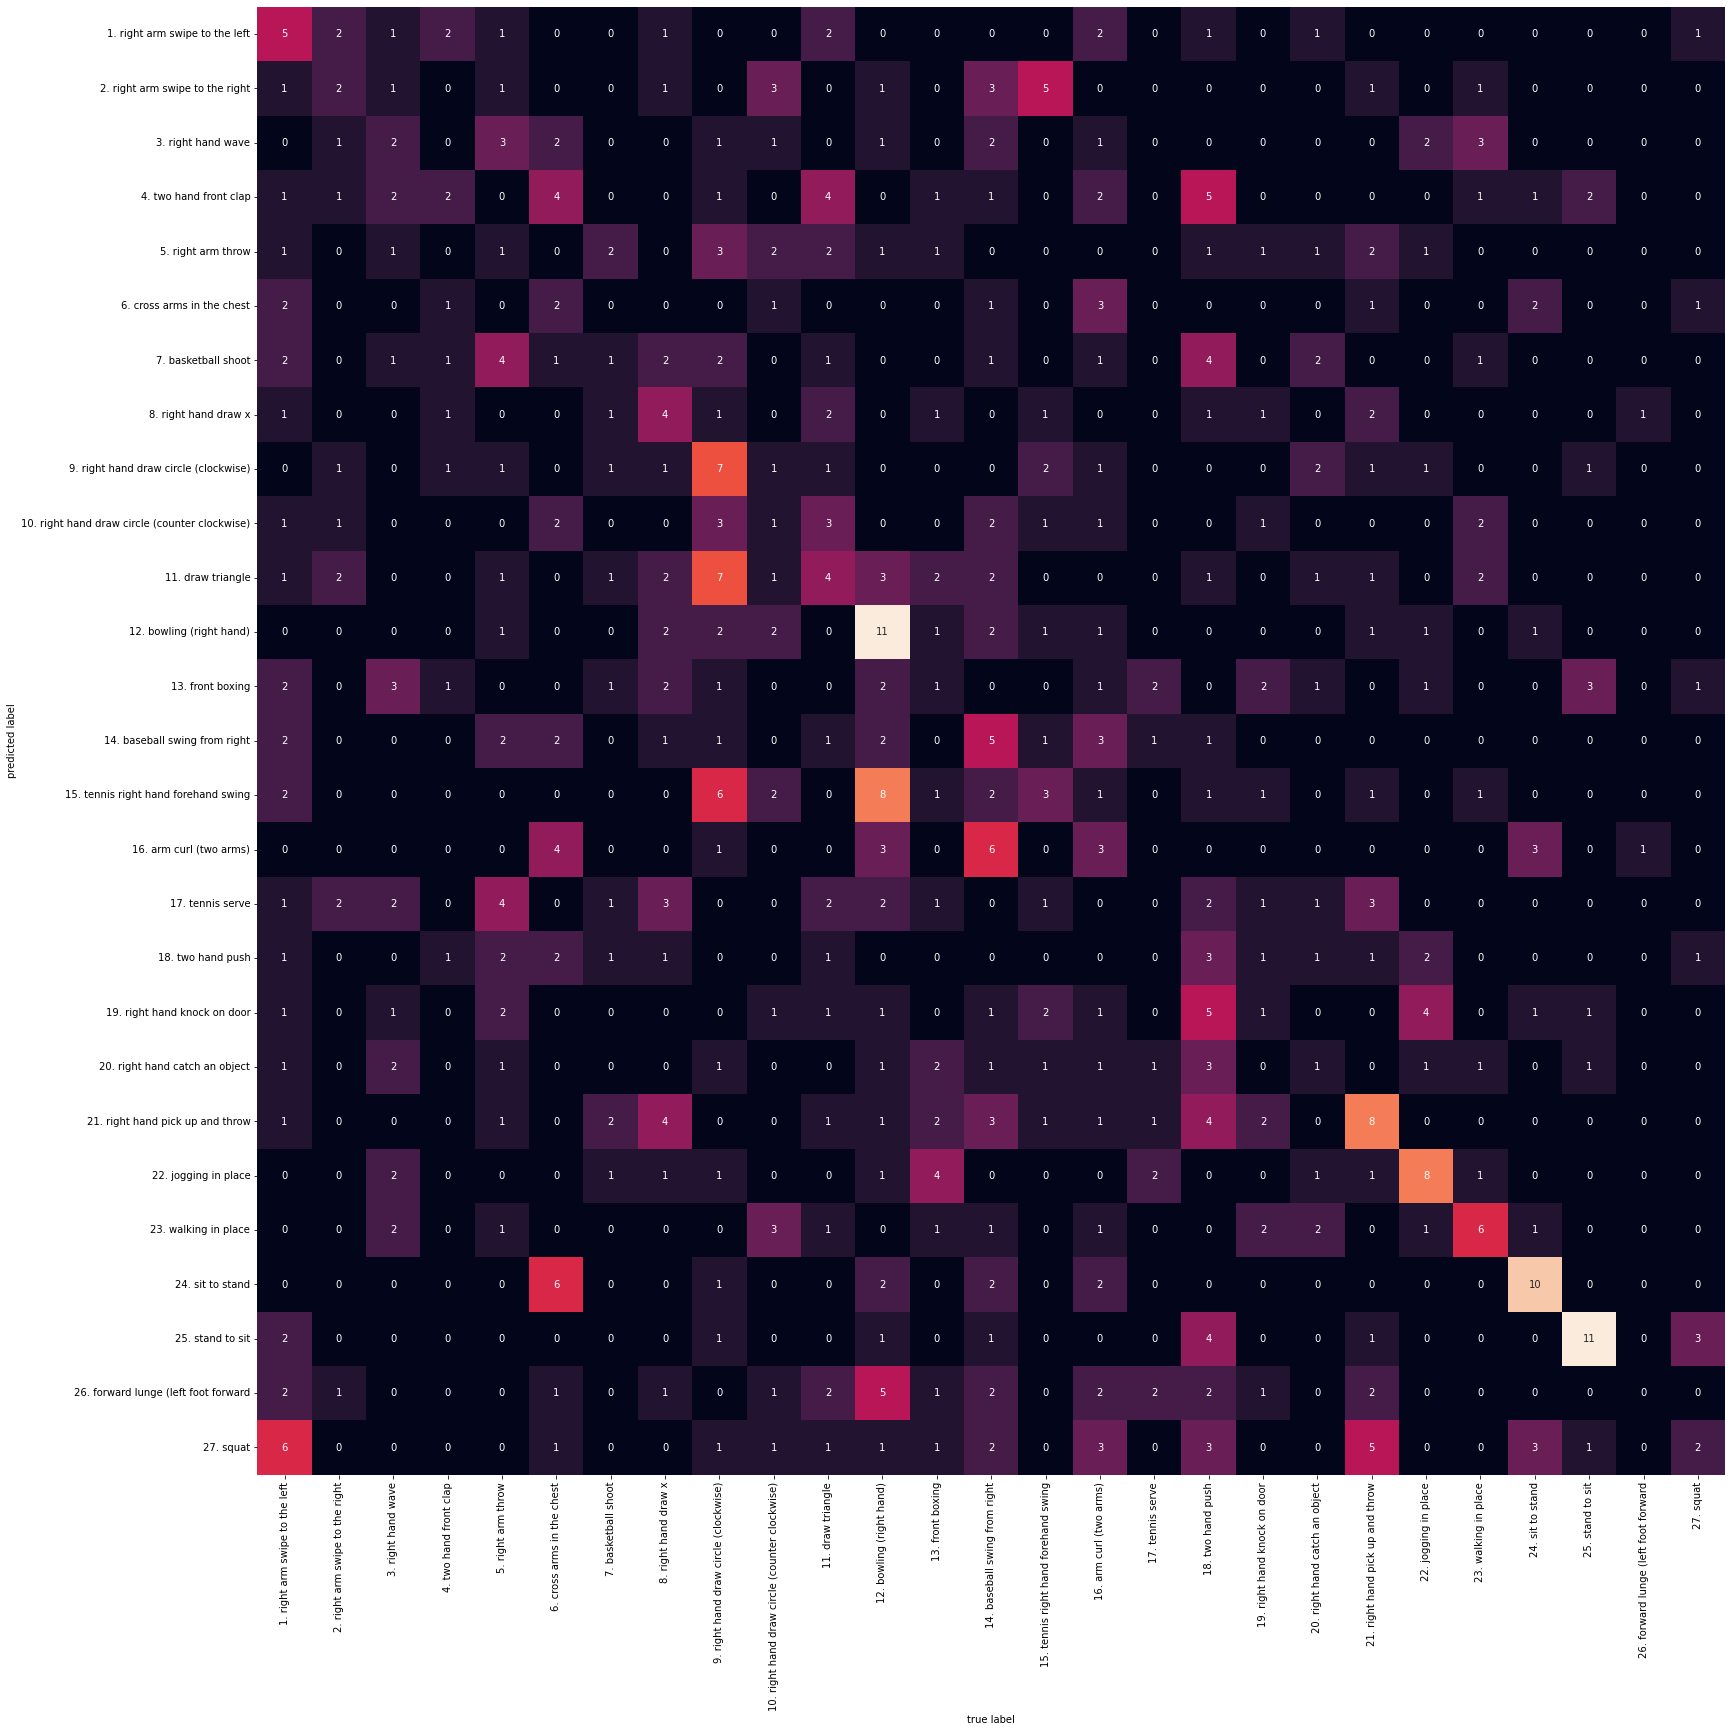

In [23]:
labels_list = []
predictions = []
classes = [
     '1. right arm swipe to the left', 
    '2. right arm swipe to the right', 
    '3. right hand wave',
    '4. two hand front clap',
    '5. right arm throw',
    '6. cross arms in the chest',
    '7. basketball shoot', 
    '8. right hand draw x',
    '9. right hand draw circle (clockwise)',
    '10. right hand draw circle (counter clockwise)',
    '11. draw triangle', 
    '12. bowling (right hand)', 
    '13. front boxing',
    '14. baseball swing from right',
    '15. tennis right hand forehand swing',
    '16. arm curl (two arms)', 
    '17. tennis serve', 
    '18. two hand push',
    '19. right hand knock on door', 
    '20. right hand catch an object',
    '21. right hand pick up and throw',
    '22. jogging in place',
    '23. walking in place',
    '24. sit to stand', 
    '25. stand to sit', 
    '26. forward lunge (left foot forward',
    '27. squat'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic RNN model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(27, 27))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')